In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/3001FinalProject/data

train.csv  train_demo_subset.csv


In [ ]:
from IPython.core.magic import register_cell_magic 
from IPython.display import HTML, display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import scipy.stats as stats
import statsmodels.formula.api as smf

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

# import beepy

pd.options.mode.chained_assignment = None

DATA_PATH = 'drive/MyDrive/3001FinalProject/data/'
# DATA_FN   = "train_demo_subset.csv"
DATA_FN   = "train.csv"

In [ ]:
data = pd.read_csv(DATA_PATH+DATA_FN)
print(data.shape)
data

(1023552, 44)


,Unnamed: 0,id,stmt_date,HQ_city,legal_struct,ateco_sector,def_date,fs_year,asst_intang_fixed,asst_tang_fixed,...,inc_extraord,taxes,profit,days_rec,ebitda,roa,roe,wc_net,margin_fin,cf_operations
0,17,520288,2011-12-31,28.0,SRL,14.0,NaT,2011,67537.0,1137566.0,...,-309.0,-80959.0,-81288.0,NaN,6318.0,-3.81,-28.03,496258.0,-917029.0,-849.0
1,18,520288,2008-12-31,28.0,SRL,14.0,NaT,2008,256438.0,1181416.0,...,-678.0,-94622.0,-107382.0,NaN,46088.0,-2.76,NaN,97952.0,NaN,-3881.0
2,19,520288,2009-12-31,28.0,SRL,14.0,NaT,2009,194046.0,1152014.0,...,4224.0,-74235.0,-77819.0,NaN,67611.0,-2.17,NaN,-210671.0,NaN,32618.0
3,21,520288,2012-12-31,28.0,SRL,14.0,NaT,2012,15195.0,1116938.0,...,3634.0,-250786.0,-250786.0,NaN,-161478.0,-12.99,NaN,367892.0,-1094962.0,-168907.0
4,22,520288,2007-12-31,28.0,SRL,14.0,NaT,2007,126603.0,1127807.0,...,820.0,92192.0,36733.0,NaN,153060.0,6.20,52.43,-317007.0,-1184970.0,80039.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023547,4885791,92001230520,2011-12-31,52.0,SPA,93.0,NaT,2011,1498628.0,248233.0,...,-2.0,85977.0,-268445.0,-15.33,984567.0,2.16,-43.00,204689.0,-1286111.0,550755.0
1023548,4885792,92001230520,2008-12-31,52.0,SPA,93.0,NaT,2008,2465065.0,343015.0,...,15339.0,356795.0,6467.0,23.01,1746442.0,12.97,1.01,-472335.0,-2212557.0,945705.0
1023549,4885793,92001230520,2007-12-31,52.0,SPA,93.0,NaT,2007,2375606.0,261775.0,...,117032.0,168871.0,3893.0,33.64,1539957.0,6.15,0.62,-78424.0,-2033489.0,1166064.0
1023550,4885815,94111750108,2010-12-31,10.0,SRL,68.0,NaT,2010,2973.0,1131586.0,...,0.0,-4793.0,-4793.0,NaN,-4795.0,-0.31,-1.85,148203.0,-1140392.0,-4793.0


In [ ]:
data[data['cf_operations'] < 0].shape

(230089, 44)

In [ ]:
def preprocessor(df, relevantAttributes = [], preproc_params = {}, new = True):
    df = df.replace(np.nan, 0) # replace all NaN with 0

    # Replacing values with absolute values
    for key in df.keys()[8:]:
      if key not in ['AR','profit','roa','roe','wc_net','ebitda','prof_financing','prof_operating']:
        df[key] = np.abs(df[key])

    df['stmt_date'] = pd.to_datetime(df['stmt_date'], format='%Y-%m-%d') 
    df['def_date'] = pd.to_datetime(df['def_date'], format='%d/%m/%Y')  

    df['default'] = np.where(df['fs_year']== df['def_date'].dt.year-1, 1, 0) # create default target 

    # df[['def_date_shift','default_shift']] = df.groupby('id')['def_date','default'].shift(-1)
    April_prior = df[df['def_date'].dt.month <= 4] # yes shift
    April_after = df[(df['def_date'].dt.month > 4) | (pd.isnull(df['def_date'].dt.month))] # no shift
    April_prior[['def_date','default']] = April_prior[April_prior['def_date'].dt.month <= 4].groupby('id')[['def_date','default']].shift(-1) # shift
    df = pd.concat([April_prior, April_after]) # recombine

    new_df = df.dropna(subset = ['default']) # drop rows due to nulls being created by shift 

    # # outlier handling
    # for key in relevantAttributes:
    #   zscores = np.asarray(new_df[key] - np.mean(new_df[key]))/np.std(new_df[key])
    #   # print(np.sum(np.isnan(zscores)))
    #   outliers = (zscores > 1) + (zscores < -1)
    #   new_df[key] = new_df[key]*(~outliers) + new_df[key]*(outliers)/100

    # # # Features extracted
    # # new_df,new_features = feature_extraction_modified(new_df)


    # # Normalization
    # for key in relevantAttributes:
    #   new_df[key] = (new_df[key] - np.mean(new_df[key]))/np.std(new_df[key])

    return(new_df, preproc_params)

In [ ]:
df,_= preprocessor(data)

In [ ]:
df.dtypes

Unnamed: 0                       int64
id                               int64
stmt_date               datetime64[ns]
HQ_city                        float64
legal_struct                    object
ateco_sector                   float64
def_date                datetime64[ns]
fs_year                          int64
asst_intang_fixed              float64
asst_tang_fixed                float64
asst_fixed_fin                 float64
asst_current                   float64
AR                             float64
cash_and_equiv                 float64
asst_tot                       float64
eqty_tot                       float64
eqty_corp_family_tot           float64
liab_lt                        float64
liab_lt_emp                    float64
debt_bank_st                   float64
debt_bank_lt                   float64
debt_fin_st                    float64
debt_fin_lt                    float64
AP_st                          float64
AP_lt                          float64
debt_st                  

In [ ]:
df = df.drop(columns=['Unnamed: 0','id','stmt_date','HQ_city','legal_struct','ateco_sector','def_date','fs_year','default'])

In [ ]:
df.dtypes

asst_intang_fixed       float64
asst_tang_fixed         float64
asst_fixed_fin          float64
asst_current            float64
AR                      float64
cash_and_equiv          float64
asst_tot                float64
eqty_tot                float64
eqty_corp_family_tot    float64
liab_lt                 float64
liab_lt_emp             float64
debt_bank_st            float64
debt_bank_lt            float64
debt_fin_st             float64
debt_fin_lt             float64
AP_st                   float64
AP_lt                   float64
debt_st                 float64
debt_lt                 float64
rev_operating           float64
COGS                    float64
prof_operations         float64
goodwill                float64
inc_financing           float64
exp_financing           float64
prof_financing          float64
inc_extraord            float64
taxes                   float64
profit                  float64
days_rec                float64
ebitda                  float64
roa     

In [ ]:
parameters = df.agg(['mean','std']).to_dict()

In [ ]:
import pickle

In [ ]:
with open(DATA_PATH+'parameters.pkl', 'wb') as f:
    pickle.dump(parameters, f)

In [ ]:
with open(DATA_PATH+'parameters.pkl', 'rb') as f:
    parameters = pickle.load(f)

In [ ]:
relevantAttributes = ['asst_tot','eqty_tot','profit']
for key in relevantAttributes:
      zscores = np.asarray(data[key] - parameters[key]['mean'])/parameters[key]['std']
zscores

array([-0.01887355, -0.02181285, -0.01848279, ..., -0.00927852,
       -0.01025694, -0.01230501])

# Histograms

In [ ]:
df = df.drop(columns=['Unnamed: 0','id', 'stmt_date','def_date'])
df.shape

(1018737, 41)

In [ ]:
df['default'].value_counts()

0.0    1008083
1.0      10654
Name: default, dtype: int64

In [ ]:
df.columns

Index(['HQ_city', 'legal_struct', 'ateco_sector', 'fs_year',
       'asst_intang_fixed', 'asst_tang_fixed', 'asst_fixed_fin',
       'asst_current', 'AR', 'cash_and_equiv', 'asst_tot', 'eqty_tot',
       'eqty_corp_family_tot', 'liab_lt', 'liab_lt_emp', 'debt_bank_st',
       'debt_bank_lt', 'debt_fin_st', 'debt_fin_lt', 'AP_st', 'AP_lt',
       'debt_st', 'debt_lt', 'rev_operating', 'COGS', 'prof_operations',
       'goodwill', 'inc_financing', 'exp_financing', 'prof_financing',
       'inc_extraord', 'taxes', 'profit', 'days_rec', 'ebitda', 'roa', 'roe',
       'wc_net', 'margin_fin', 'cf_operations', 'default'],
      dtype='object')

In [ ]:
df.dtypes

HQ_city                 float64
legal_struct             object
ateco_sector            float64
fs_year                   int64
asst_intang_fixed       float64
asst_tang_fixed         float64
asst_fixed_fin          float64
asst_current            float64
AR                      float64
cash_and_equiv          float64
asst_tot                float64
eqty_tot                float64
eqty_corp_family_tot    float64
liab_lt                 float64
liab_lt_emp             float64
debt_bank_st            float64
debt_bank_lt            float64
debt_fin_st             float64
debt_fin_lt             float64
AP_st                   float64
AP_lt                   float64
debt_st                 float64
debt_lt                 float64
rev_operating           float64
COGS                    float64
prof_operations         float64
goodwill                float64
inc_financing           float64
exp_financing           float64
prof_financing          float64
inc_extraord            float64
taxes   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


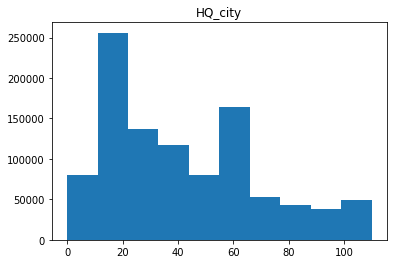

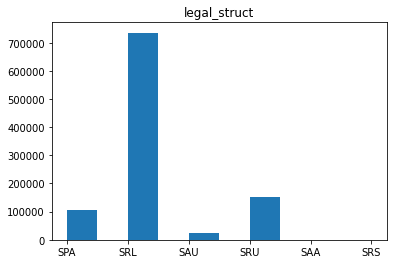

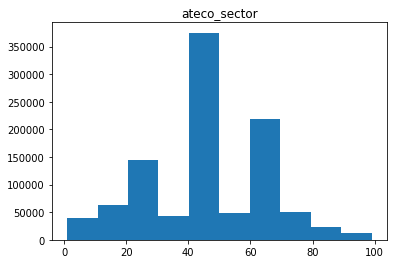

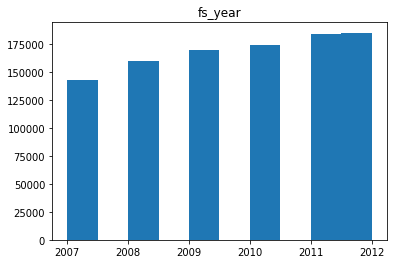

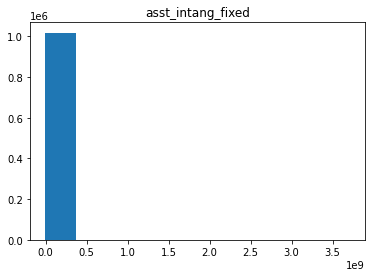

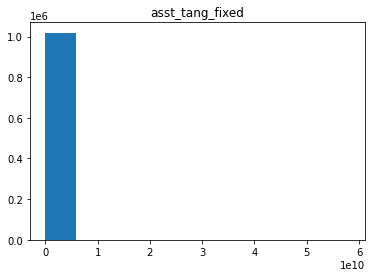

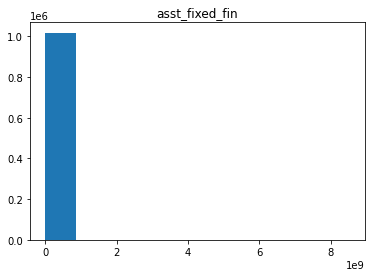

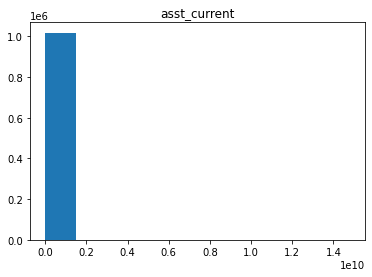

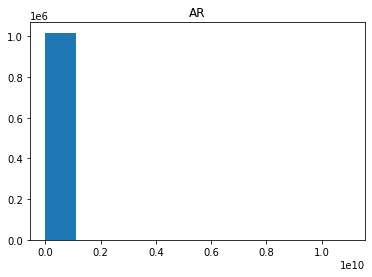

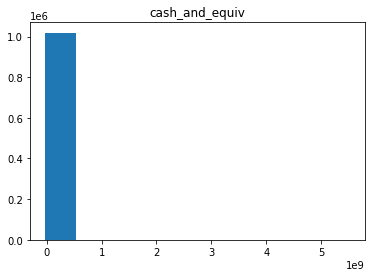

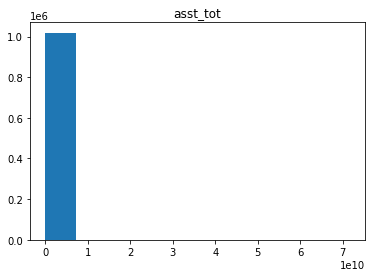

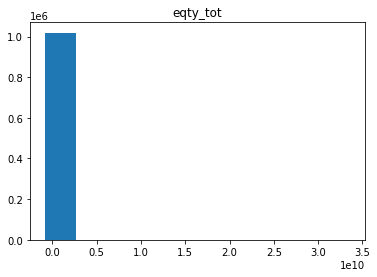

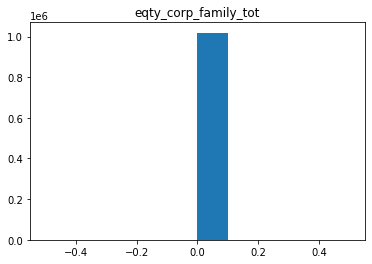

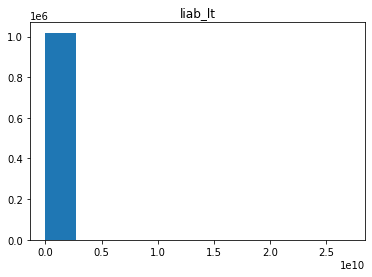

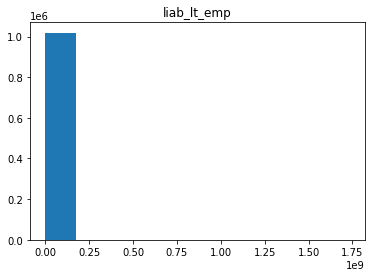

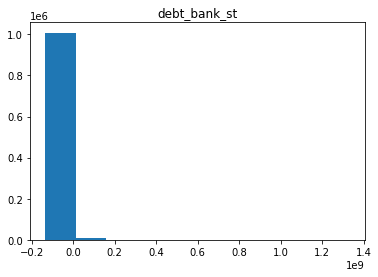

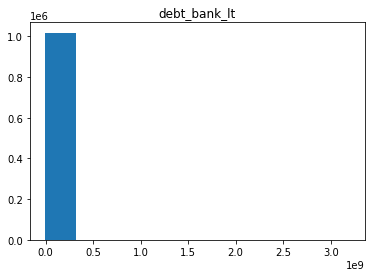

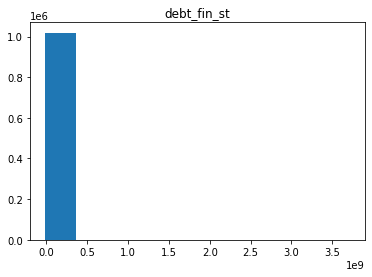

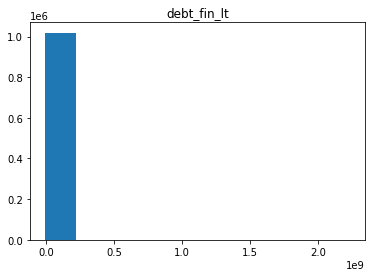

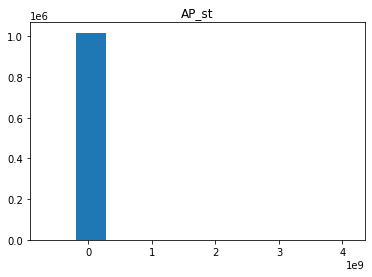

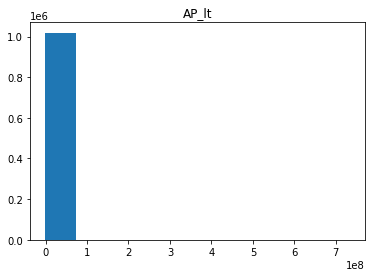

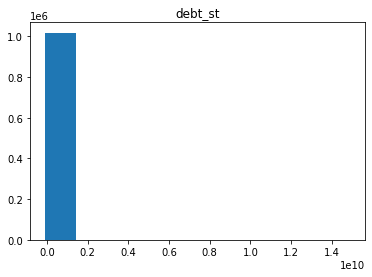

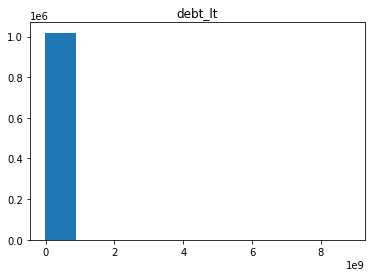

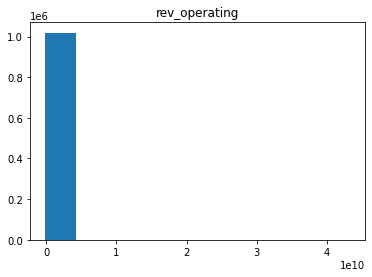

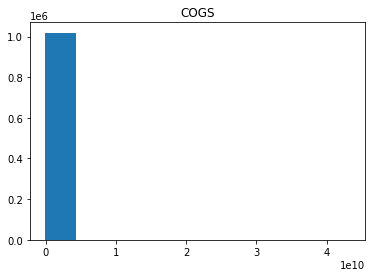

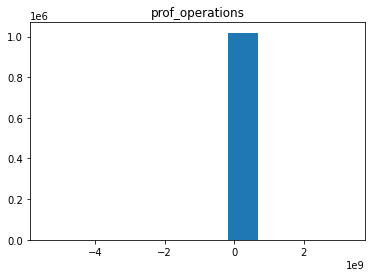

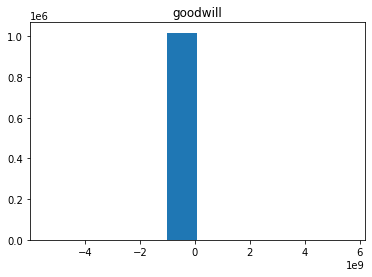

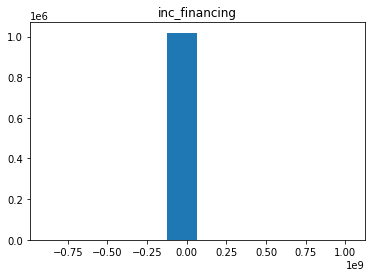

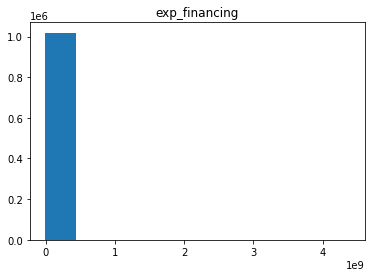

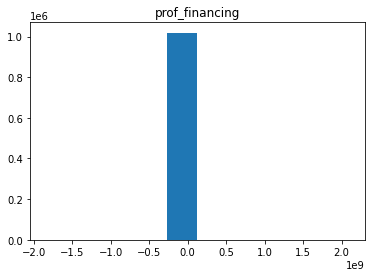

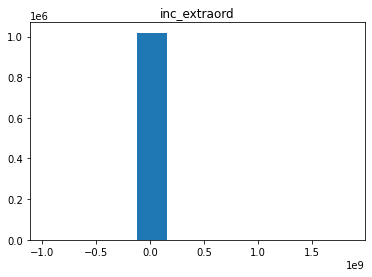

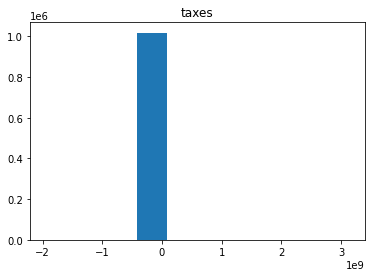

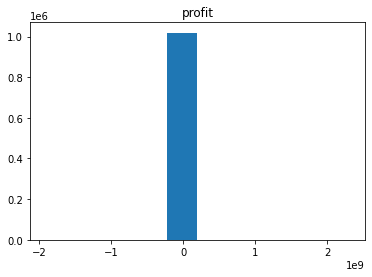

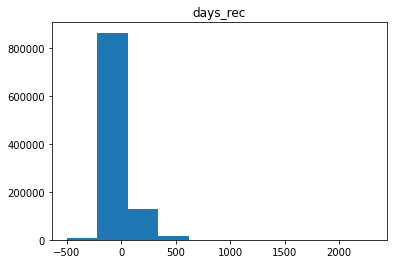

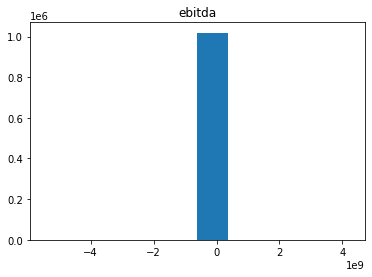

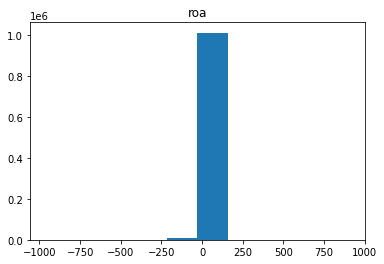

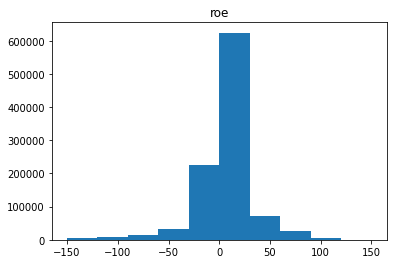

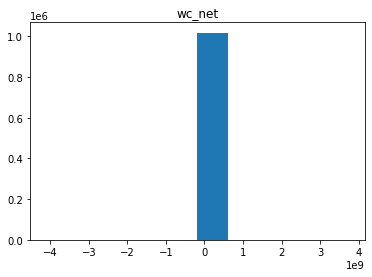

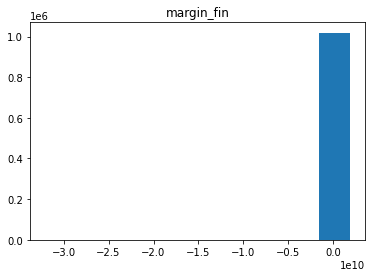

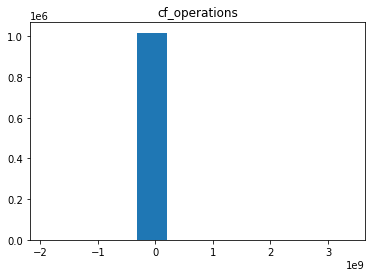

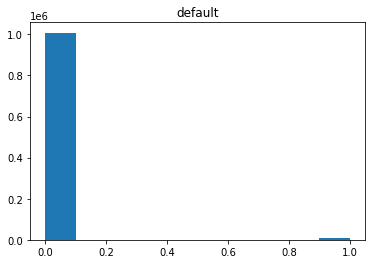

In [ ]:
for i in df.columns:
    plt.figure()
    plt.hist(df[i].dropna())
    plt.title(i)

# Correlations

In [ ]:
corr = df.corr()

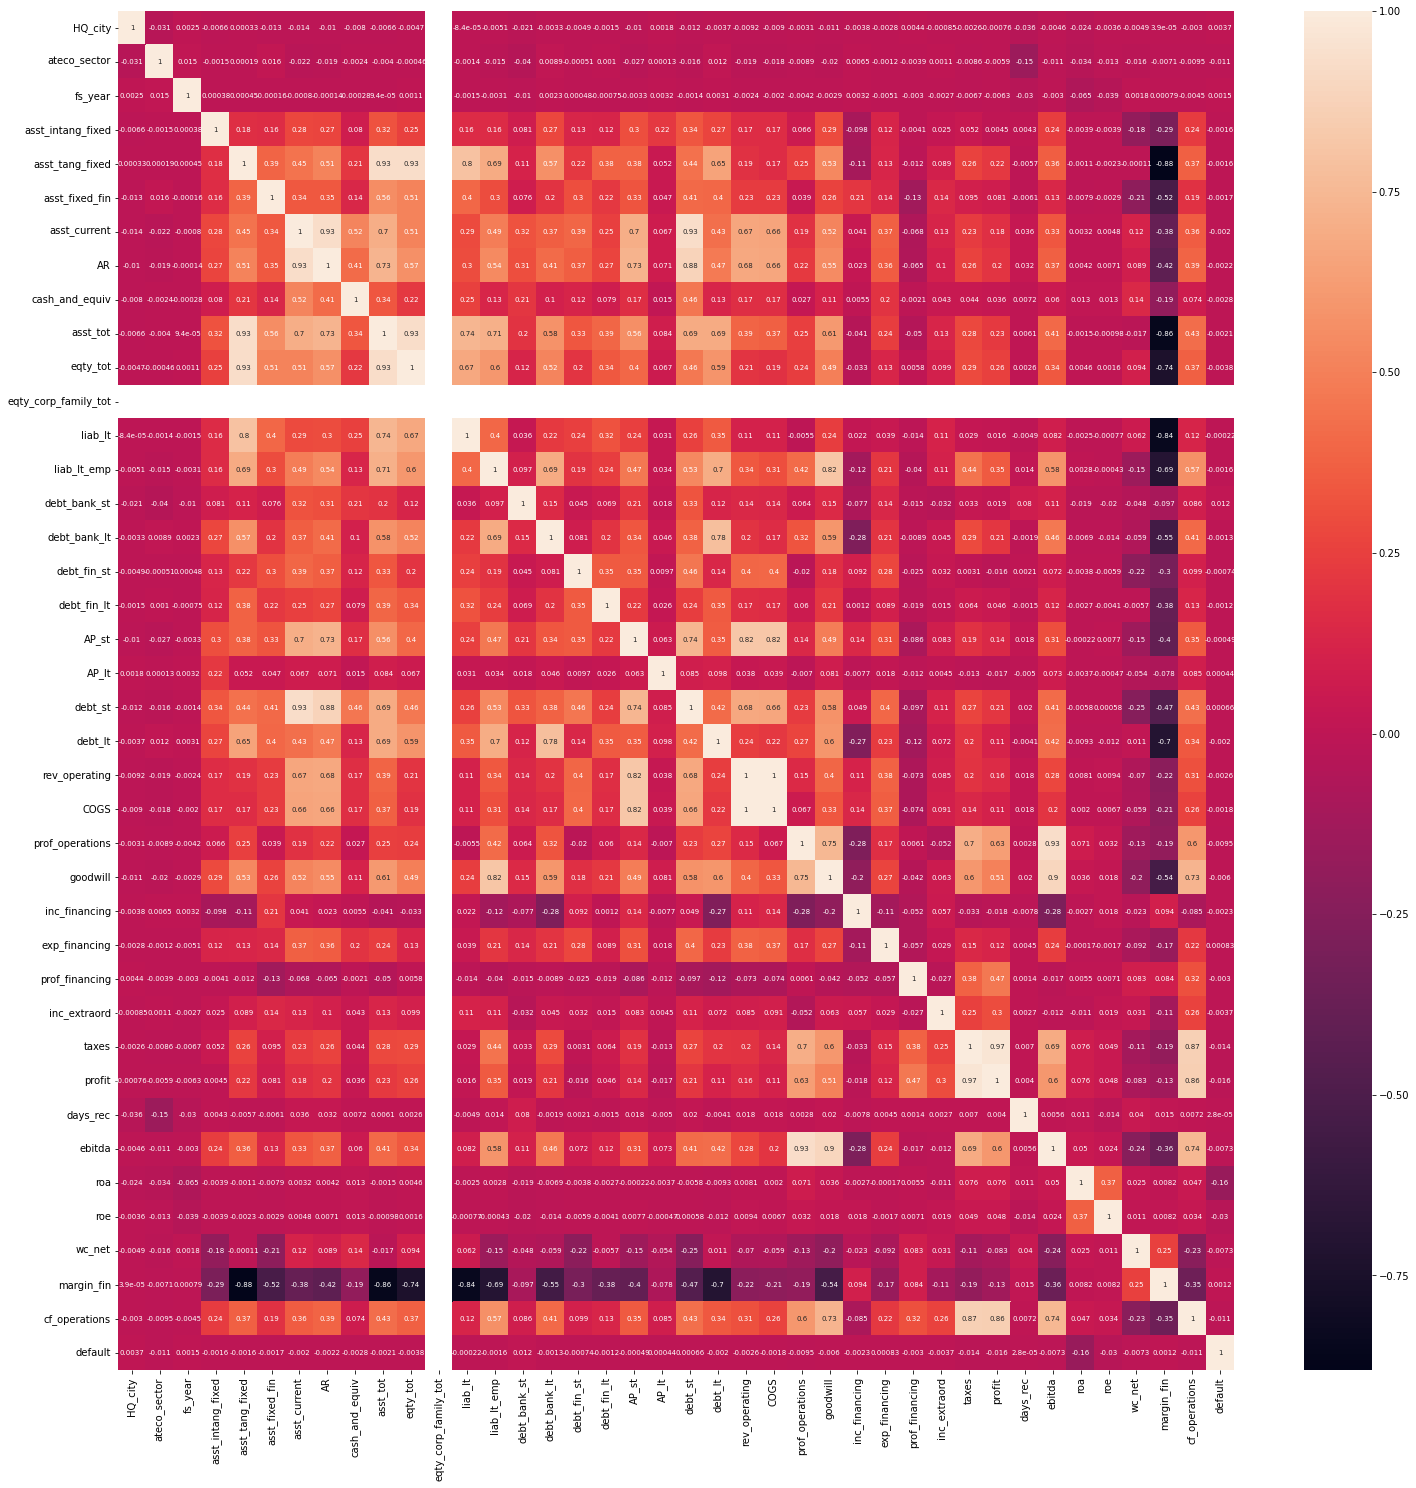

In [ ]:
plt.figure(figsize = (25,25))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True, annot_kws={"size": 7})

In [ ]:
data['eqty_corp_family_tot'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: eqty_corp_family_tot, dtype: float64

# Remove outliers

In [ ]:
# df_no_na.dtypes

In [ ]:
remove_outliers = df.copy()
remove_outliers = remove_outliers.drop(columns=['legal_struct','fs_year'])

In [ ]:
remove_outliers = remove_outliers[(np.abs(stats.zscore(remove_outliers['profit'])) < 3)]

In [ ]:
remove_outliers.shape

(1017150, 39)

In [ ]:
remove_outliers['profit'].describe()

count    1.017150e+06
mean     6.408833e+04
std      1.218693e+06
min     -2.650899e+07
25%     -2.126300e+04
50%      1.100200e+04
75%      8.537975e+04
max      2.671651e+07
Name: profit, dtype: float64

(array([2.36000e+02, 3.72000e+02, 8.30000e+02, 2.53600e+03, 7.84462e+05,
        2.23967e+05, 3.00000e+03, 9.68000e+02, 5.11000e+02, 2.68000e+02]),
 array([-26508991. , -21186440.6, -15863890.2, -10541339.8,  -5218789.4,
           103761. ,   5426311.4,  10748861.8,  16071412.2,  21393962.6,
         26716513. ]),
 <a list of 10 Patch objects>)

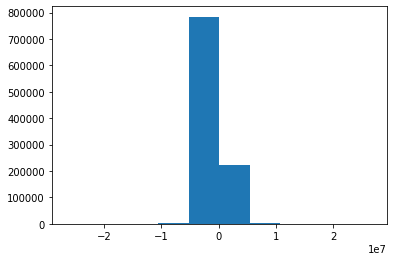

In [ ]:
plt.hist(remove_outliers['profit'])

In [ ]:
df.shape

(1018737, 41)

In [ ]:
df['profit'].describe()

count    1.018737e+06
mean     8.626418e+04
std      8.877618e+06
min     -1.914960e+09
25%     -2.135100e+04
50%      1.101600e+04
75%      8.571000e+04
max      2.314332e+09
Name: profit, dtype: float64